# Security and Exchange Commision - Edgar database API

Financial reports for US-listed companies.

- Do not require authentication or API key
- Access forms 10-Q, 10-K, 8-K, 20-F, 40-F, 6-K, and their variants
- Reports in XBRL format (eXtensible Business Reporting Language) 

API documentation:
https://www.sec.gov/edgar/sec-api-documentation


Combines with
CEO dismissal database


In [84]:
%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [183]:
import requests
import pandas as pd
from pandas import json_normalize
import json
import matplotlib.pyplot as plt

In [182]:
plt.style.use("seaborn")

In [109]:
# SEC Edgar database API
# https://www.sec.gov/edgar/sec-api-documentation

# history of submissions of financial report fillings
url_submissions = "https://data.sec.gov/submissions/"

# a few quarters of financial reports 
url_facts = "https://data.sec.gov/api/xbrl/companyfacts/"

# hisotry of values for a specific financial report entry (e.g. Revenues)
# for a specific company
url_concepts = "https://data.sec.gov/api/xbrl/companyconcepts/"

# ...
url_frames = "https://data.sec.gov/api/xbrl/frames/"

In [107]:
# url_facts
# test with Apple Inc.
# Apple Inc. CIK found manually from https://www.sec.gov/edgar/searchedgar/cik.htm

apple_cik = "0000320193"
headers = {"User-Agent": "Anselme Borgeaud (individual) aborgeaud@gmail.com"}

def get_facts(cik: str, headers) -> dict:
    assert len(cik) == 10
    resp = requests.get(url_facts + "CIK" + apple_cik + ".json", headers=headers, timeout=5)
    resp_json = None
    if resp.status_code < 400:
        resp_json = resp.json()
    return resp_json

https://data.sec.gov/api/xbrl/companyfacts/CIK0000320193.json


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [108]:
resp_json.keys()

dict_keys(['cik', 'entityName', 'facts'])

In [90]:
cik_str = f"{resp_json['cik']:010d}"
cik_str

'0000320193'

In [91]:
resp_json["entityName"]

'Apple Inc.'

In [92]:
# keys of resp_json['facts'] are the taxonomies (e.g., us-gaap, ifrs-full, dei, or srt)
resp_json["facts"].keys()

dict_keys(['dei', 'us-gaap'])

In [93]:
gaap = resp_json["facts"]["us-gaap"]

In [198]:
resp_json["facts"]["dei"].keys()

dict_keys(['EntityCommonStockSharesOutstanding', 'EntityPublicFloat'])

In [197]:
for i, k in enumerate(gaap.keys()):
    if i < 20:
        print(f"{i} - {k}")

0 - AccountsPayable
1 - AccountsPayableCurrent
2 - AccountsReceivableNetCurrent
3 - AccruedIncomeTaxesCurrent
4 - AccruedIncomeTaxesNoncurrent
5 - AccruedLiabilities
6 - AccruedLiabilitiesCurrent
7 - AccruedMarketingCostsCurrent
8 - AccumulatedDepreciationDepletionAndAmortizationPropertyPlantAndEquipment
9 - AccumulatedOtherComprehensiveIncomeLossAvailableForSaleSecuritiesAdjustmentNetOfTax
10 - AccumulatedOtherComprehensiveIncomeLossCumulativeChangesInNetGainLossFromCashFlowHedgesEffectNetOfTax
11 - AccumulatedOtherComprehensiveIncomeLossForeignCurrencyTranslationAdjustmentNetOfTax
12 - AccumulatedOtherComprehensiveIncomeLossNetOfTax
13 - AdjustmentsToAdditionalPaidInCapitalSharebasedCompensationRequisiteServicePeriodRecognitionValue
14 - AdjustmentsToAdditionalPaidInCapitalTaxEffectFromShareBasedCompensation
15 - AdvertisingExpense
16 - AllocatedShareBasedCompensationExpense
17 - AllowanceForDoubtfulAccountsReceivableCurrent
18 - AmortizationOfIntangibleAssets
19 - AntidilutiveSecuri

In [201]:
for i, k in enumerate(gaap.keys()):
    print(f"{i} - {k}")

0 - AccountsPayable
1 - AccountsPayableCurrent
2 - AccountsReceivableNetCurrent
3 - AccruedIncomeTaxesCurrent
4 - AccruedIncomeTaxesNoncurrent
5 - AccruedLiabilities
6 - AccruedLiabilitiesCurrent
7 - AccruedMarketingCostsCurrent
8 - AccumulatedDepreciationDepletionAndAmortizationPropertyPlantAndEquipment
9 - AccumulatedOtherComprehensiveIncomeLossAvailableForSaleSecuritiesAdjustmentNetOfTax
10 - AccumulatedOtherComprehensiveIncomeLossCumulativeChangesInNetGainLossFromCashFlowHedgesEffectNetOfTax
11 - AccumulatedOtherComprehensiveIncomeLossForeignCurrencyTranslationAdjustmentNetOfTax
12 - AccumulatedOtherComprehensiveIncomeLossNetOfTax
13 - AdjustmentsToAdditionalPaidInCapitalSharebasedCompensationRequisiteServicePeriodRecognitionValue
14 - AdjustmentsToAdditionalPaidInCapitalTaxEffectFromShareBasedCompensation
15 - AdvertisingExpense
16 - AllocatedShareBasedCompensationExpense
17 - AllowanceForDoubtfulAccountsReceivableCurrent
18 - AmortizationOfIntangibleAssets
19 - AntidilutiveSecuri

In [95]:
gaap["Revenues"].keys()

dict_keys(['label', 'description', 'units'])

In [96]:
gaap["Revenues"]["units"].keys()

dict_keys(['USD'])

In [97]:
revenues = gaap["Revenues"]["units"]["USD"]

revenues[0].keys()

dict_keys(['start', 'end', 'val', 'accn', 'fy', 'fp', 'form', 'filed', 'frame'])

In [98]:
for revenue in revenues:
    print(f"{revenue['start']} to {revenue['end']}")

2015-09-27 to 2016-09-24
2016-09-25 to 2016-12-31
2017-01-01 to 2017-04-01
2017-04-02 to 2017-07-01
2016-09-25 to 2017-09-30
2017-07-02 to 2017-09-30
2017-10-01 to 2017-12-30
2017-12-31 to 2018-03-31
2018-04-01 to 2018-06-30
2017-10-01 to 2018-09-29
2018-07-01 to 2018-09-29


In [99]:
df_revenues = json_normalize(revenues)
df_revenues

,start,end,val,accn,fy,fp,form,filed,frame
0,2015-09-27,2016-09-24,215639000000,0000320193-18-000145,2018,FY,10-K,2018-11-05,CY2016
1,2016-09-25,2016-12-31,78351000000,0000320193-18-000145,2018,FY,10-K,2018-11-05,CY2016Q4
2,2017-01-01,2017-04-01,52896000000,0000320193-18-000145,2018,FY,10-K,2018-11-05,CY2017Q1
3,2017-04-02,2017-07-01,45408000000,0000320193-18-000145,2018,FY,10-K,2018-11-05,CY2017Q2
4,2016-09-25,2017-09-30,229234000000,0000320193-18-000145,2018,FY,10-K,2018-11-05,CY2017
5,2017-07-02,2017-09-30,52579000000,0000320193-18-000145,2018,FY,10-K,2018-11-05,CY2017Q3
6,2017-10-01,2017-12-30,88293000000,0000320193-18-000145,2018,FY,10-K,2018-11-05,CY2017Q4
7,2017-12-31,2018-03-31,61137000000,0000320193-18-000145,2018,FY,10-K,2018-11-05,CY2018Q1
8,2018-04-01,2018-06-30,53265000000,0000320193-18-000145,2018,FY,10-K,2018-11-05,CY2018Q2
9,2017-10-01,2018-09-29,265595000000,0000320193-18-000145,2018,FY,10-K,2018-11-05,CY2018


In [100]:
df_quarter_revenues = df_revenues[df_revenues["frame"].str.contains("Q")]
df_quarter_revenues

,start,end,val,accn,fy,fp,form,filed,frame
1,2016-09-25,2016-12-31,78351000000,0000320193-18-000145,2018,FY,10-K,2018-11-05,CY2016Q4
2,2017-01-01,2017-04-01,52896000000,0000320193-18-000145,2018,FY,10-K,2018-11-05,CY2017Q1
3,2017-04-02,2017-07-01,45408000000,0000320193-18-000145,2018,FY,10-K,2018-11-05,CY2017Q2
5,2017-07-02,2017-09-30,52579000000,0000320193-18-000145,2018,FY,10-K,2018-11-05,CY2017Q3
6,2017-10-01,2017-12-30,88293000000,0000320193-18-000145,2018,FY,10-K,2018-11-05,CY2017Q4
7,2017-12-31,2018-03-31,61137000000,0000320193-18-000145,2018,FY,10-K,2018-11-05,CY2018Q1
8,2018-04-01,2018-06-30,53265000000,0000320193-18-000145,2018,FY,10-K,2018-11-05,CY2018Q2
10,2018-07-01,2018-09-29,62900000000,0000320193-18-000145,2018,FY,10-K,2018-11-05,CY2018Q3


<AxesSubplot:xlabel='frame'>

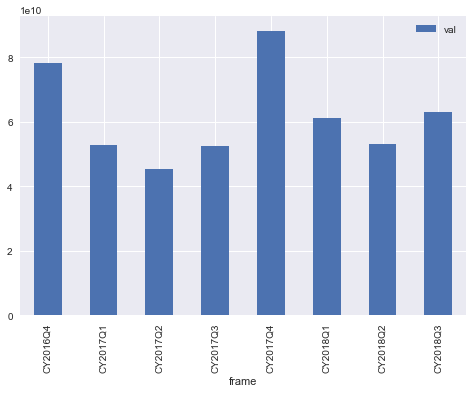

In [82]:
df_quarter_revenues.plot(x="frame", y="val", kind="bar")

In [111]:
# submissions


def get_submissions(cik: str, headers) -> dict:
    assert len(cik) == 10
    resp = requests.get(
        url_submissions + "CIK" + apple_cik + ".json", headers=headers, timeout=5
    )
    resp_json = None
    if resp.status_code < 400:
        resp_json = resp.json()
    return resp_json

In [112]:
submission_json = get_submissions(apple_cik, headers)

In [113]:
submission_json.keys()

dict_keys(['cik', 'entityType', 'sic', 'sicDescription', 'insiderTransactionForOwnerExists', 'insiderTransactionForIssuerExists', 'name', 'tickers', 'exchanges', 'ein', 'description', 'website', 'investorWebsite', 'category', 'fiscalYearEnd', 'stateOfIncorporation', 'stateOfIncorporationDescription', 'addresses', 'phone', 'flags', 'formerNames', 'filings'])

In [122]:
submission_json["filings"]["recent"]

['4',
 '4',
 '4',
 '8-K',
 '4',
 '424B2',
 'FWP',
 '424B2',
 'IRANNOTICE',
 '10-Q',
 '8-K',
 '4',
 '4',
 '10-Q',
 '8-K',
 '4',
 '4',
 '4',
 '4',
 '4',
 '4',
 '4',
 '4',
 '4',
 '4',
 '4',
 '4',
 '8-K',
 'PX14A6G',
 'SC 13G/A',
 'SD',
 'SC 13G/A',
 '8-K',
 'SC 13G/A',
 '4',
 '4',
 '4',
 '4',
 '4',
 '4',
 '4',
 '4',
 '424B2',
 'FWP',
 '424B2',
 '10-Q',
 '8-K',
 '4',
 '3',
 'DEFA14A',
 'DEF 14A',
 '8-K',
 '4',
 '4',
 '10-K',
 '8-K',
 '4',
 '4',
 '4',
 '4',
 '4',
 '4',
 '4',
 '4',
 '4',
 '4',
 '4',
 '4',
 '4',
 '4',
 '8-K',
 '424B2',
 'FWP',
 '424B2',
 '8-K',
 '10-Q',
 '8-K',
 '4',
 '8-K',
 '424B2',
 'FWP',
 '424B2',
 '10-Q',
 '4',
 '8-K',
 '4',
 '4',
 '4',
 '4',
 '4',
 '4',
 '4',
 '4',
 '4',
 '4',
 '4',
 '8-K',
 '8-K',
 'SC 13G/A',
 'SC 13G/A',
 'SC 13G/A',
 'SD',
 '4',
 '4',
 '4',
 '4',
 '4',
 '4',
 '4',
 '10-Q',
 '8-K',
 'PX14A6G',
 'PX14A6G',
 'DEFA14A',
 'DEF 14A',
 '4',
 'CERT',
 '8-A12B',
 '8-K',
 '4',
 '424B2',
 '4',
 'FWP',
 '424B2',
 'S-8 POS',
 '10-K',
 '8-K',
 '4',
 '4',
 '4',
 

In [203]:
submission_json["insiderTransactionForIssuerExists"]

1

In [138]:
# company concepts

concepts = requests.get(
    f"https://data.sec.gov/api/xbrl/companyconcept/CIK{apple_cik}/us-gaap/AccountsPayableCurrent.json",
    headers=headers,
)

concepts_json = concepts.json()

In [139]:
concepts_json.keys()

dict_keys(['cik', 'taxonomy', 'tag', 'label', 'description', 'entityName', 'units'])

In [159]:
df_accpay = json_normalize(concepts_json["units"]["USD"])
df_accpay

,end,val,accn,fy,fp,form,filed,frame
0,2008-09-27,5520000000,0001193125-09-214859,2009,FY,10-K,2009-10-27,NaN
1,2008-09-27,5520000000,0001193125-10-012091,2009,FY,10-K/A,2010-01-25,CY2008Q3I
2,2009-09-26,5601000000,0001193125-09-214859,2009,FY,10-K,2009-10-27,NaN
3,2009-09-26,5601000000,0001193125-10-012085,2010,Q1,10-Q,2010-01-25,NaN
4,2009-09-26,5601000000,0001193125-10-012091,2009,FY,10-K/A,2010-01-25,NaN
...,...,...,...,...,...,...,...,...
97,2020-09-26,42296000000,0000320193-21-000056,2021,Q2,10-Q,2021-04-29,NaN
98,2020-09-26,42296000000,0000320193-21-000065,2021,Q3,10-Q,2021-07-28,CY2020Q3I
99,2020-12-26,63846000000,0000320193-21-000010,2021,Q1,10-Q,2021-01-28,CY2020Q4I
100,2021-03-27,40127000000,0000320193-21-000056,2021,Q2,10-Q,2021-04-29,CY2021Q1I


In [160]:
df_accpay_quarterly = df_accpay[df_revenues["fp"].str.contains("Q")]

In [161]:
df_accpay_quarterly["period"] = (
    df_accpay_quarterly["fy"].astype("str") + df_accpay_quarterly["fp"]
)

/var/folders/57/h9v24nzx4pj9gx46p1yhvwxm0000gn/T/ipykernel_95956/3969407865.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_accpay_quarterly["period"] = (


<AxesSubplot:xlabel='period'>

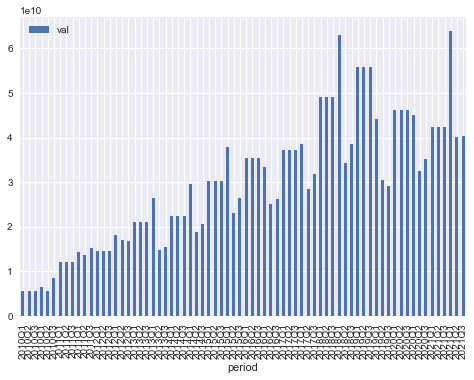

In [162]:
df_accpay_quarterly.plot(x="period", y="val", kind="bar")

# Yahoo Finance API

In [173]:
from datetime import datetime, date, time, timezone


def yahoo_url(ticker: str, from_day: str, to_day: str) -> str:
    """Get url to request yahoo finance."""
    from_dt = int(
        datetime.combine(
            date.fromisoformat(from_day), time(), tzinfo=timezone.utc
        ).timestamp()
    )
    to_dt = int(
        datetime.combine(
            date.fromisoformat(to_day), time(), tzinfo=timezone.utc
        ).timestamp()
    )
    return (
        "https://query1.finance.yahoo.com/v7/finance/download/"
        f"{ticker.upper()}"
        f"?period1={from_dt}&period2={to_dt}&interval=1d"
        "&events=history&includeAdjustedClose=true"
    )

In [174]:
ticker = "AAPL"
from_day = "2021-01-01"
to_day = "2021-09-01"

url = yahoo_url(ticker, from_day, to_day)
headers = {"User-Agent": "Chrome/92.0.4515.159"}

resp = requests.get(url, headers=headers, timeout=5)
print(resp.status_code)

200


In [187]:
ticker_infos = resp.content.decode("utf-8")

In [189]:
import io

df_ticker = pd.read_csv(io.StringIO(ticker_infos))
df_ticker

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-01-04,133.520004,133.610001,126.760002,129.410004,128.804825,143301900
1,2021-01-05,128.889999,131.740005,128.429993,131.009995,130.397324,97664900
2,2021-01-06,127.720001,131.050003,126.379997,126.599998,126.007957,155088000
3,2021-01-07,128.360001,131.630005,127.860001,130.919998,130.307755,109578200
4,2021-01-08,132.429993,132.630005,130.229996,132.050003,131.432465,105158200
...,...,...,...,...,...,...,...
162,2021-08-25,149.809998,150.320007,147.800003,148.360001,148.360001,58991300
163,2021-08-26,148.350006,149.119995,147.509995,147.539993,147.539993,48597200
164,2021-08-27,147.479996,148.750000,146.830002,148.600006,148.600006,55721500
165,2021-08-30,149.000000,153.490005,148.610001,153.119995,153.119995,90956700


In [191]:
df_ticker["Date"] = pd.to_datetime(df_ticker["Date"])

<AxesSubplot:xlabel='Date'>

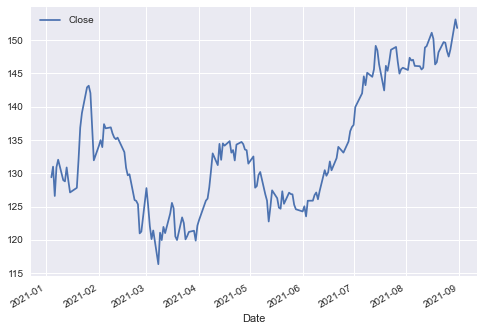

In [192]:
df_ticker.plot(x="Date", y="Close", kind="line")